## Machine Learning Pipeline: Wrapping up for Deployment


In the previous notebooks, we worked through the typical Machine Learning pipeline steps to build a regression model that allows us to predict house prices. Briefly, we transformed variables in the dataset to make them suitable for use in a Regression model, then we selected the most predictive variables and finally we trained our model.

Now, we want to deploy our model. We want to create an API, which we can call with new data, with new characteristics about houses, to get an estimate of the SalePrice. In order to do so, we need to write code in a very specific way. We will show you how to write production code in the next sections.

Here, we will summarise the key pieces of code, that we need to take forward for this particular project, to put our model in production.

Let's go ahead and get started.

### Setting the seed

It is important to note, that we are engineering variables and pre-processing data with the idea of deploying the model. Therefore, from now on, for each step that includes some element of randomness, it is extremely important that we **set the seed**. This way, we can obtain reproducibility between our research and our development code.

This is perhaps one of the most important lessons that you need to take away from this course: **Always set the seeds**.

Let's go ahead and load the dataset.

In [2]:
# to handle datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import MinMaxScaler

# to build the models
from sklearn.linear_model import Lasso

# to evaluate the models
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

# to persist the model and the scaler
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

import warnings
warnings.simplefilter(action='ignore')


## Load data

We need the training data to train our model in the production environment. 

In [3]:
# load dataset
data = pd.read_csv('Indizes.csv')
data = data.drop(data.columns[0],axis=1)
data = data.drop(data.columns[0],axis=1)
#data = data['Eröffnung_x'.replace('.','')



#data['Eröffnung_x'] = data['Eröffnung_x'].astype("float64")
#data['Eröffnung_y'] = data['Eröffnung_y'].astype("float64")
#data = data.drop(data.columns[0],axis=1)
print(data)
#data.head()
data.info()

#data = data['Eröffnung_x'.replace('.','')



#data['Eröffnung_x'] = data['Eröffnung_x'].astype("float64")
#data['Eröffnung_y'] = data['Eröffnung_y'].astype("float64")
#data = data.drop(data.columns[0],axis=1)
print(data)
#data.head()
data.info()


      Schluss DAX  Schluss EURO STOXX 50  Schluss Dow Jones  Schluss SMI  \
0         2548.37                2124.78            8214.60      4230.70   
1         2636.10                2184.98            8280.20      4263.60   
2         2579.33                2172.64            8229.80      4247.10   
3         2584.05                2132.51            8201.40      4194.50   
4         2520.84                2132.11            8145.70      4207.60   
...           ...                    ...                ...          ...   
3772     14142.09                3840.01           33811.40     12258.33   
3773     13924.17                3757.59           34049.46     12084.98   
3774     13756.40                3721.36           33240.18     11933.28   
3775     13793.94                3734.64           33301.93     12051.48   
3776     13979.84                3777.02           33916.39     12068.41   

      Schluss MSCI World  Schluss FTSE  Schluss ATX  Schluss SDAX  \
0                7

<AxesSubplot:>

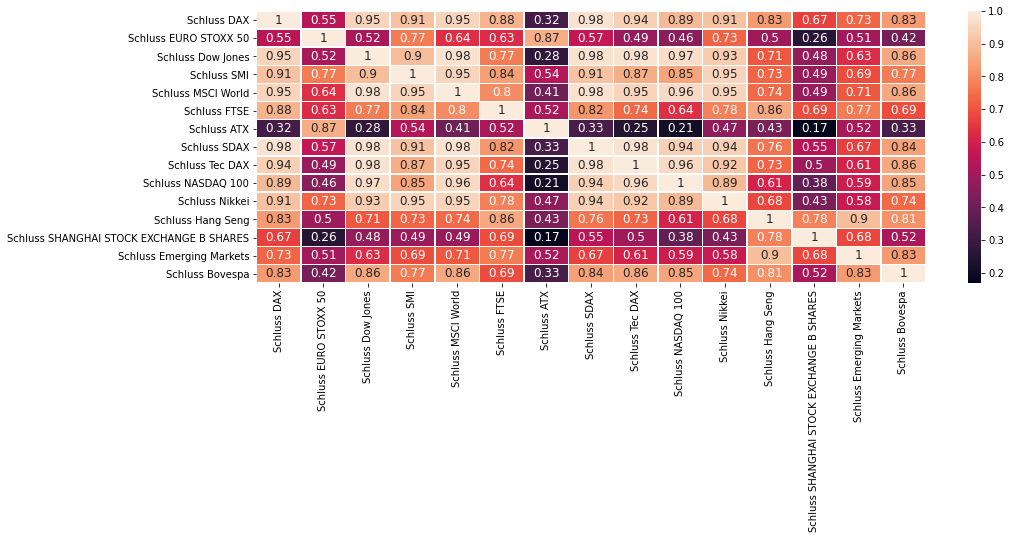

In [4]:
import seaborn as sns
df_heatmap = data.corr().round(2)
f, ax = plt.subplots(figsize=(15, 5))
sns.heatmap(df_heatmap, annot=True, annot_kws={'size': 12}, linewidths=.5)

## Separate dataset into train and test

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    data,
    data['Schluss DAX'],
    test_size=0.1,
    # we are setting the seed here
    random_state=0)

X_train.shape, X_test.shape


((3399, 15), (378, 15))

In [7]:
X_train.head()


,Schluss DAX,Schluss EURO STOXX 50,Schluss Dow Jones,Schluss SMI,Schluss MSCI World,Schluss FTSE,Schluss ATX,Schluss SDAX,Schluss Tec DAX,Schluss NASDAQ 100,Schluss Nikkei,Schluss Hang Seng,Schluss SHANGHAI STOCK EXCHANGE B SHARES,Schluss Emerging Markets,Schluss Bovespa
1710,6346.19,2462.36,12231.11,5852.66,1254.203,5702.24,2065.30,4661.45,716.82,2401.290,9050.47,20019.24,253.584,1010.119,59333.53
326,3854.41,2734.37,9749.99,5309.70,1047.084,4564.50,2082.97,2874.10,491.41,1432.570,10659.15,12818.10,86.240,464.380,22602.60
3221,12490.74,3532.87,27349.19,9965.15,2209.587,7556.86,3017.63,11075.25,2912.46,7954.564,21620.88,28465.65,287.382,1055.486,103704.28
1364,5654.48,2793.29,10185.53,6496.33,1129.287,5247.41,2541.25,3668.68,812.90,1760.720,10205.02,20243.75,237.617,934.223,66664.96
3696,15380.79,4137.11,35227.03,12375.35,3117.306,7232.28,3745.00,16113.44,3752.95,15846.158,27927.37,23348.23,281.885,1213.958,107038.91


## Selected features

In [8]:
# load selected features
features = pd.read_csv('selected_features.csv')

# Added the extra feature, LotFrontage
features = features['0'].to_list() + ['LotFrontage']

print('Number of features: ', len(features))


FileNotFoundError: [Errno 2] No such file or directory: 'selected_features.csv'

## Engineer missing values

### Categorical variables

For categorical variables, we will replace missing values with the string "missing".

In [9]:
# make a list of the categorical variables that contain missing values

vars_with_na = [
    var for var in features
    if X_train[var].isnull().sum() > 0 and X_train[var].dtypes == 'O'
]

# display categorical variables that we will engineer:
vars_with_na


NameError: name 'features' is not defined

Note that we have much less categorical variables with missing values than in our original dataset. But we still use categorical variables with NA for the final model, so we need to include this piece of feature engineering logic in the deployment pipeline. 

In [10]:
# I bring forward the code used in the feature engineering notebook:
# (step 2)

X_train[vars_with_na] = X_train[vars_with_na].fillna('Missing')
X_test[vars_with_na] = X_test[vars_with_na].fillna('Missing')

# check that we have no missing information in the engineered variables
X_train[vars_with_na].isnull().sum()


NameError: name 'vars_with_na' is not defined

### Numerical variables

To engineer missing values in numerical variables, we will:

- add a binary missing value indicator variable
- and then replace the missing values in the original variable with the mode


In [11]:
# make a list of the numerical variables that contain missing values:

vars_with_na = [
    var for var in features
    if X_train[var].isnull().sum() > 0 and X_train[var].dtypes != 'O'
]

# display numerical variables with NA
vars_with_na


NameError: name 'features' is not defined

In [12]:
# I bring forward the code used in the feature engineering notebook
# with minor adjustments (step 2):

var = 'LotFrontage'

# calculate the mode
mode_val = X_train[var].mode()[0]
print('mode of LotFrontage: {}'.format(mode_val))

# replace missing values by the mode
# (in train and test)
X_train[var] = X_train[var].fillna(mode_val)
X_test[var] = X_test[var].fillna(mode_val)


KeyError: 'LotFrontage'

## Temporal variables

One of our temporal variables was selected to be used in the final model: 'YearRemodAdd'

So we need to deploy the bit of code that creates it.

In [13]:
# create the temporal var "elapsed years"

# I bring this bit of code forward from the notebook on feature
# engineering (step 2)

def elapsed_years(df, var):
    # capture difference between year variable
    # and year in which the house was sold
    
    df[var] = df['YrSold'] - df[var]
    
    return df


In [14]:
X_train = elapsed_years(X_train, 'YearRemodAdd')
X_test = elapsed_years(X_test, 'YearRemodAdd')


KeyError: 'YrSold'

### Numerical variable transformation

In [15]:
# we apply the logarithmic function to the variables that
# were selected (and the target):

for var in ['LotFrontage', '1stFlrSF', 'GrLivArea', 'SalePrice']:
    X_train[var] = np.log(X_train[var])
    X_test[var] = np.log(X_test[var])
    

KeyError: 'LotFrontage'

## Categorical variables

### Group rare labels

In [13]:
# let's capture the categorical variables first

cat_vars = [var for var in features if X_train[var].dtype == 'O']

cat_vars


['MSZoning',
 'Neighborhood',
 'RoofStyle',
 'MasVnrType',
 'BsmtQual',
 'BsmtExposure',
 'HeatingQC',
 'CentralAir',
 'KitchenQual',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'PavedDrive']

In [14]:
# bringing thise from the notebook on feature engineering (step 2):

def find_frequent_labels(df, var, rare_perc):
    
    # function finds the labels that are shared by more than
    # a certain % of the houses in the dataset

    df = df.copy()

    tmp = df.groupby(var)['SalePrice'].count() / len(df)

    return tmp[tmp > rare_perc].index


for var in cat_vars:
    
    # find the frequent categories
    frequent_ls = find_frequent_labels(X_train, var, 0.01)
    print(var)
    print(frequent_ls)
    print()
    
    # replace rare categories by the string "Rare"
    X_train[var] = np.where(X_train[var].isin(
        frequent_ls), X_train[var], 'Rare')
    
    X_test[var] = np.where(X_test[var].isin(
        frequent_ls), X_test[var], 'Rare')
    

MSZoning
Index(['FV', 'RH', 'RL', 'RM'], dtype='object', name='MSZoning')

Neighborhood
Index(['Blmngtn', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr', 'Crawfor',
       'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel', 'NAmes', 'NWAmes',
       'NoRidge', 'NridgHt', 'OldTown', 'SWISU', 'Sawyer', 'SawyerW',
       'Somerst', 'StoneBr', 'Timber'],
      dtype='object', name='Neighborhood')

RoofStyle
Index(['Gable', 'Hip'], dtype='object', name='RoofStyle')

MasVnrType
Index(['BrkFace', 'None', 'Stone'], dtype='object', name='MasVnrType')

BsmtQual
Index(['Ex', 'Fa', 'Gd', 'Missing', 'TA'], dtype='object', name='BsmtQual')

BsmtExposure
Index(['Av', 'Gd', 'Missing', 'Mn', 'No'], dtype='object', name='BsmtExposure')

HeatingQC
Index(['Ex', 'Fa', 'Gd', 'TA'], dtype='object', name='HeatingQC')

CentralAir
Index(['N', 'Y'], dtype='object', name='CentralAir')

KitchenQual
Index(['Ex', 'Fa', 'Gd', 'TA'], dtype='object', name='KitchenQual')

FireplaceQu
Index(['Ex', 'Fa', 'Gd', 'Missing', 'Po

### Encoding of categorical variables


In [15]:
# this function will assign discrete values to the strings of the variables,
# so that the smaller value corresponds to the category that shows the smaller
# mean house sale price


def replace_categories(train, test, var, target):

    # order the categories in a variable from that with the lowest
    # house sale price, to that with the highest
    ordered_labels = train.groupby([var])[target].mean().sort_values().index

    # create a dictionary of ordered categories to integer values
    ordinal_label = {k: i for i, k in enumerate(ordered_labels, 0)}

    # use the dictionary to replace the categorical strings by integers
    train[var] = train[var].map(ordinal_label)
    test[var] = test[var].map(ordinal_label)
    
    print(var)
    print(ordinal_label)
    print()
    

In [16]:
for var in cat_vars:
    replace_categories(X_train, X_test, var, 'SalePrice')
    

MSZoning
{'Rare': 0, 'RM': 1, 'RH': 2, 'RL': 3, 'FV': 4}

Neighborhood
{'IDOTRR': 0, 'MeadowV': 1, 'BrDale': 2, 'Edwards': 3, 'BrkSide': 4, 'OldTown': 5, 'Sawyer': 6, 'SWISU': 7, 'NAmes': 8, 'Mitchel': 9, 'SawyerW': 10, 'Rare': 11, 'NWAmes': 12, 'Gilbert': 13, 'Blmngtn': 14, 'CollgCr': 15, 'Crawfor': 16, 'ClearCr': 17, 'Somerst': 18, 'Timber': 19, 'StoneBr': 20, 'NridgHt': 21, 'NoRidge': 22}

RoofStyle
{'Gable': 0, 'Rare': 1, 'Hip': 2}

MasVnrType
{'None': 0, 'Rare': 1, 'BrkFace': 2, 'Stone': 3}

BsmtQual
{'Missing': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}

BsmtExposure
{'Missing': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}

HeatingQC
{'Rare': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}

CentralAir
{'N': 0, 'Y': 1}

KitchenQual
{'Fa': 0, 'TA': 1, 'Gd': 2, 'Ex': 3}

FireplaceQu
{'Po': 0, 'Missing': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}

GarageType
{'Missing': 0, 'Rare': 1, 'Detchd': 2, 'Basment': 3, 'Attchd': 4, 'BuiltIn': 5}

GarageFinish
{'Missing': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}

PavedDrive

In [17]:
# check absence of na
[var for var in features if X_train[var].isnull().sum() > 0]


[]

In [18]:
# check absence of na
[var for var in features if X_test[var].isnull().sum() > 0]


[]

### Feature Scaling

For use in linear models, features need to be either scaled or normalised. In the next section, I will scale features between the min and max values:

In [43]:
# capture the target
y_train = X_train['Eröffnung_y']
y_test = X_test['Eröffnung_y']


In [72]:
scaler = MinMaxScaler()
scaler.fit(X_train)
IndexListe= ["DAX", "EURO STOXX 50", "Dow Jones",  "SMI", "MSCI World", "FTSE", "ATX", "SDAX", "Tec DAX", "NASDAQ 100", "Nikkei", "Hang Seng", "SHANGHAI STOCK EXCHANGE B SHARES", "Emerging Markets", "Bovespa"]
scaled = scaler.transform(X_train)
for i, col in enumerate(IndexListe):
    X_train[col] = scaled[:,i]

scaled_test = scaler.transform(X_test)

print('Vor dem Scaling:')
display(X_test.head())

for i, col in enumerate(IndexListe):
    X_test[col] = scaled_test[:,i]

print('\nNach dem Scaling:')
display(X_test.head())




Vor dem Scaling:


,Schluss DAX,Schluss EURO STOXX 50,Schluss Dow Jones,Schluss SMI,Schluss MSCI World,Schluss FTSE,Schluss ATX,Schluss SDAX,Schluss Tec DAX,Schluss NASDAQ 100,Schluss Nikkei,Schluss Hang Seng,Schluss SHANGHAI STOCK EXCHANGE B SHARES,Schluss Emerging Markets,Schluss Bovespa
501,4911.17,3338.99,10544.90,6731.58,1215.582,5347.40,3405.57,4194.61,599.10,1589.630,12834.25,15086.62,68.940,635.550,29049.990
3745,12831.51,3505.29,32632.64,11057.06,2797.696,6964.11,2972.99,13084.80,2920.93,13267.604,24790.95,20741.04,273.716,1096.047,111239.360
2486,10210.44,3221.14,16330.40,8778.76,1625.403,6155.81,2281.31,8711.25,1729.78,4296.299,18299.62,21562.50,303.544,804.157,46503.994
1976,8058.37,2744.70,14539.14,7842.85,1440.207,6529.41,2512.70,6031.49,927.39,2807.300,12381.19,22619.18,262.874,1047.698,57281.020
989,6393.39,3558.66,12392.66,7013.87,1400.352,5605.80,3600.40,4310.88,716.22,1761.050,11964.16,21384.61,245.681,1065.940,61932.700



Nach dem Scaling:


,Schluss DAX,Schluss EURO STOXX 50,Schluss Dow Jones,Schluss SMI,Schluss MSCI World,Schluss FTSE,Schluss ATX,Schluss SDAX,Schluss Tec DAX,Schluss NASDAQ 100,Schluss Nikkei,Schluss Hang Seng,Schluss SHANGHAI STOCK EXCHANGE B SHARES,Schluss Emerging Markets,Schluss Bovespa,DAX,EURO STOXX 50,Dow Jones,SMI,MSCI World,FTSE,ATX,SDAX,Tec DAX,NASDAQ 100,Nikkei,Hang Seng,SHANGHAI STOCK EXCHANGE B SHARES,Emerging Markets,Bovespa
501,4911.17,3338.99,10544.90,6731.58,1215.582,5347.40,3405.57,4194.61,599.10,1589.630,12834.25,15086.62,68.940,635.550,29049.990,0.179616,0.555438,0.130787,0.299287,0.205879,0.430147,0.589480,0.159055,0.074117,0.036903,0.244728,0.269548,0.036307,0.313781,0.150329
3745,12831.51,3505.29,32632.64,11057.06,2797.696,6964.11,2972.99,13084.80,2920.93,13267.604,24790.95,20741.04,273.716,1096.047,111239.360,0.751569,0.616137,0.862043,0.788541,0.824018,0.809061,0.476067,0.724661,0.712468,0.791667,0.751043,0.498686,0.458741,0.711530,0.836817
2486,10210.44,3221.14,16330.40,8778.76,1625.403,6155.81,2281.31,8711.25,1729.78,4296.299,18299.62,21562.50,303.544,804.157,46503.994,0.562293,0.512423,0.322327,0.530843,0.365998,0.619617,0.294723,0.446410,0.384980,0.211838,0.476163,0.531974,0.520273,0.459413,0.296114
1976,8058.37,2744.70,14539.14,7842.85,1440.207,6529.41,2512.70,6031.49,927.39,2807.300,12381.19,22619.18,262.874,1047.698,57281.020,0.406885,0.338522,0.263024,0.424982,0.293641,0.707179,0.355389,0.275920,0.164375,0.115602,0.225542,0.574795,0.436375,0.669769,0.386129
989,6393.39,3558.66,12392.66,7013.87,1400.352,5605.80,3600.40,4310.88,716.22,1761.050,11964.16,21384.61,245.681,1065.940,61932.700,0.286652,0.635617,0.191961,0.331216,0.278070,0.490709,0.640561,0.166453,0.106317,0.047982,0.207883,0.524765,0.400907,0.685525,0.424982


In [21]:
# explore maximum values of variables
scaler.data_max_


array([190.        ,   4.        ,  22.        ,  10.        ,
         9.        ,  60.        ,   2.        ,   3.        ,
         4.        ,   4.        ,   4.        ,   1.        ,
         8.45361421,   8.63799389,   3.        ,   3.        ,
         3.        ,   5.        ,   5.        ,   3.        ,
         4.        ,   2.        ,   5.74620319])

In [22]:
# explore minimum values of variables
scaler.data_min_


array([20.        ,  0.        ,  0.        ,  1.        ,  1.        ,
       -1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  5.81114099,  5.81114099,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  3.04452244])

In [73]:
# transform the train and test set, and add on the Id and SalePrice variables
X_train = scaler.transform(X_train[features])
X_test = scaler.transform(X_test[features])


NameError: name 'features' is not defined

## Train the Linear Regression: Lasso

In [76]:
# set up the model
# remember to set the random_state / seed

lin_model = Lasso(alpha=0.005, random_state=0)

# train the model
lin_model.fit(X_train, y_train)

# we persist the model for future use
#joblib.dump(lin_model, 'lasso_regression.pkl')

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import BayesianRidge
import xgboost as xgb
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoLars
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Wir kreiren hier einen Benchmarkregressor, welcher den Durchschnittswert unseres Trainingsamples als Vorhersage nimmt.
class BenchmarkRegressor:
    def __init__(self):
        pass
    
    def fit(self, X, y, **kwargs):
        self.mean = y.mean()
        
    def predict(self, X):
        return [self.mean] * len(X)
    
    def get_params(self, deep=False):
        return {}


bm_regr = BenchmarkRegressor()
lr_regr = LinearRegression()
ri_regr = Ridge()
br_regr = BayesianRidge()
ls_regr = Lasso()
ll_regr = LassoLars()
ne_regr = KNeighborsRegressor()
dt_regr = DecisionTreeRegressor()
rf_regr = RandomForestRegressor()
xg_regr = xgb.XGBRegressor()

# Liste mit dem Namen der Modelle und dem Modell selbst, dies erwartet das Pipeline Objekt von SKLearn anschliesssend als Input.
models = [
    ('Benchmark', bm_regr),
    ('LR', lr_regr),
    ('Ridge', ri_regr),
    ('Bayesian Ridge', br_regr),
    ('Lasso', ls_regr),
    ('LARS Lasso', ll_regr),
    ('Nearest Neighbors (KNN) regression', ne_regr),
    ('Decision Tree', dt_regr),
    ('Random Forest', rf_regr),
    ('XGBoost', xg_regr),
]



In [75]:
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.pipeline import FeatureUnion, Pipeline


for name, model in models:
    pipelined_model = Pipeline([ 
                                 ('pca', PCA(n_components = 3)), 
                                 (name, model)
                            ])
    
    # Training des Models
    pipelined_model.fit(X_train, y_train)
    
    # Vorhersage des trainierten models auf X_test
    y_hat = pipelined_model.predict(X_test)
    
    # Berechnung der verschiedenen Messwerte resp. KPI's
    EVS = (explained_variance_score(y_test, y_hat))
    ME = (max_error(y_test, y_hat))
    MAE = (mean_absolute_error(y_test, y_hat))
    MSE = np.sqrt(mean_squared_error(y_test, y_hat, squared=True))
    RMSE = np.sqrt(mean_squared_error(y_test, y_hat, squared=False))
    R2 = r2_score(y_test, y_hat)
    print('Model: ', name, ' | EVS: ', EVS)
    print('Model: ', name, ' | ME: ', ME)
    print('Model: ', name, ' | MAE: ', MAE)
    print('Model: ', name, ' | MSE ', MSE)
    print('Model: ', name, ' | RMSE ', RMSE)
    print('Model: ', name, ' | R2 ', R2)
    print('----------------')
 

Model:  Benchmark  | EVS:  0.0
Model:  Benchmark  | ME:  7633.753077375697
Model:  Benchmark  | MAE:  3124.499572625624
Model:  Benchmark  | MSE  3517.107573212976
Model:  Benchmark  | RMSE  59.305206965434124
Model:  Benchmark  | R2  -0.004244627664381939
----------------
Model:  LR  | EVS:  0.9634869719118642
Model:  LR  | ME:  2088.404008786675
Model:  LR  | MAE:  580.6505353071922
Model:  LR  | MSE  671.4728993108829
Model:  LR  | RMSE  25.912794123962836
Model:  LR  | R2  0.9633962827389169
----------------
Model:  Ridge  | EVS:  0.9634869719118087
Model:  Ridge  | ME:  2088.4040087426065
Model:  Ridge  | MAE:  580.6505353072744
Model:  Ridge  | MSE  671.4728993113093
Model:  Ridge  | RMSE  25.912794123971064
Model:  Ridge  | R2  0.9633962827388705
----------------
Model:  Bayesian Ridge  | EVS:  0.9634862780432609
Model:  Bayesian Ridge  | ME:  2087.8552117557856
Model:  Bayesian Ridge  | MAE:  580.6514288517786
Model:  Bayesian Ridge  | MSE  671.4782300205272
Model:  Bayesian Ri

Satisfaction predictions
R2:  0.9996739534973563
R2 for predictions:  0.999705935568188
Model:  XGBoost  | EVS:  0.9959389371335663
Model:  XGBoost  | ME:  1031.7566015624998
Model:  XGBoost  | MAE:  157.8246616908482
Model:  XGBoost  | MSE  223.76538146830103
Model:  XGBoost  | RMSE  14.958789438597664
----------------
Time:  5.486854314804077


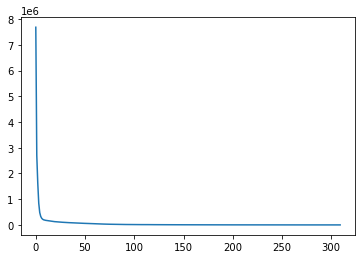

In [89]:
start = time.time()

from sklearn.neural_network import MLPRegressor
import time

nn_sat = MLPRegressor(hidden_layer_sizes = (15,15) ,max_iter=400).fit(X_train,y_train)
print('Satisfaction predictions')
print('R2: ', nn_sat.score(X_train,y_train))
plt.plot(nn_sat.loss_curve_)

predictions_nn_sat = nn_sat.predict(X_test)
print('R2 for predictions: ', nn_sat.score(X_test, y_test))
EVS = (explained_variance_score(y_test, y_hat))
ME = (max_error(y_test, y_hat))
MAE = (mean_absolute_error(y_test, y_hat))
MSE = np.sqrt(mean_squared_error(y_test, y_hat, squared=True))
RMSE = np.sqrt(mean_squared_error(y_test, y_hat, squared=False))
print('Model: ', name, ' | EVS: ', EVS)
print('Model: ', name, ' | ME: ', ME)
print('Model: ', name, ' | MAE: ', MAE)
print('Model: ', name, ' | MSE ', MSE)
print('Model: ', name, ' | RMSE ', RMSE)
print('----------------')

end = time.time()
print('Time: ', end - start)

In [82]:
std_nn = np.sqrt(sum((predictions_nn_sat - y_test)**2)/len(y_test))
print('Standard deviation: ', std_nn)

Standard deviation:  29.789525135587837


In [88]:
print(predictions_nn_sat)
print(y_test)

print(predictions_nn_sat[1])
print(y_test[3745])


[ 4871.31518359 12810.24201798 10224.19174255  8017.63128802
  6442.44548812 15662.14787482  7584.26039368 10498.93455602
  6957.87943976  5607.70951461  6025.08926026  4262.70854944
 13922.39562202  9512.05038108  7210.67140812  6217.36950223
  6853.43940196 13096.04990724 10001.90471561 10594.86983116
  5402.58892554  7939.09218708 12550.66577337 10018.01040658
  5422.49112579 13848.08279167  7472.40897688 12622.30178527
 12963.12078388  4922.50702708  3818.9432159  15925.43019253
  9758.50232609  3856.37033877  3243.0058458   7052.96156221
 13434.27036302 12075.05362344  4599.77897317  5278.23755666
  5243.91489942  3661.78501047  6503.94256673 13108.25062136
  6898.19385686  8966.66438667  7063.81727831  4832.89078149
  5147.3701857   7613.15874104  9447.22572342  4704.87117478
  5509.49165506  9045.91257171  5859.266787    6853.16517232
 12860.69954628 12631.34249655  5858.63178781 15725.59174839
  4609.55486241 13442.23433581  7429.25774074 12370.59447381
  4974.47991654  6143.86

In [77]:
# evaluate the model:
# ====================

# remember that we log transformed the output (SalePrice)
# in our feature engineering notebook (step 2).

# In order to get the true performance of the Lasso
# we need to transform both the target and the predictions
# back to the original house prices values.

# We will evaluate performance using the mean squared error and
# the root of the mean squared error and r2

# make predictions for train set
pred = lin_model.predict(X_train)

# determine mse and rmse
#print('train mse: {}'.format(int(
#    mean_squared_error(np.exp(y_train), np.exp(pred)))))
#print('train rmse: {}'.format(int(
#    sqrt(mean_squared_error(np.exp(y_train), np.exp(pred))))))
print('train r2: {}'.format(
    r2_score(np.exp(y_train), np.exp(pred))))
print()

# make predictions for test set
pred = lin_model.predict(X_test)

# determine mse and rmse
#print('test mse: {}'.format(int(
#    mean_squared_error(np.exp(y_test), np.exp(pred)))))
#print('test rmse: {}'.format(int(
#    sqrt(mean_squared_error(np.exp(y_test), np.exp(pred))))))
print('test r2: {}'.format(
    r2_score(np.exp(y_test), np.exp(pred))))
print()

print('Average house price: ', int(np.exp(y_train).median()))


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

That is all for this notebook. And that is all for this section too.

**In the next section, we will show you how to productionise this code for model deployment**.